Necessary imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

#loading Vgg16 CNN
model = torch.hub.load("pytorch/vision:v0.10.0", "vgg16", pretrained=False)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Training Dataset: http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_train.tar.gz<br>
Test Dataset: http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_test.tar.gz<br>
Downloading and extracting testing and training datasets in particular folders


In [ ]:
!wget http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_train.tar.gz
!wget http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_test.tar.gz
!mkdir Training
!mkdir Testing
!tar -xvf /content/rmastif_train.tar.gz -C /content/Training
!tar -xvf /content/rmastif_test.tar.gz -C /content/Testing

Streaming output truncated to the last 5000 lines.
00007/00026_00003.ppm
00007/00003_00000.ppm
00007/00009_00002.ppm
00007/00037_00001.ppm
00007/00019_00000.ppm
00007/00022_00002.ppm
00007/00027_00000.ppm
00007/00037_00002.ppm
00007/00018_00002.ppm
00007/00001_00002.ppm
00007/00033_00003.ppm
00007/00022_00000.ppm
00007/00038_00001.ppm
00007/00034_00000.ppm
00007/00021_00003.ppm
00007/00038_00000.ppm
00007/00027_00001.ppm
00007/00023_00002.ppm
00007/00005_00000.ppm
00007/00015_00000.ppm
00007/00006_00002.ppm
00007/00012_00000.ppm
00007/00018_00001.ppm
00007/00000_00001.ppm
00007/00024_00000.ppm
00007/00030_00000.ppm
00007/00021_00002.ppm
00007/00025_00002.ppm
00007/00019_00002.ppm
00007/00013_00002.ppm
00007/00020_00002.ppm
00007/00028_00000.ppm
00007/00005_00003.ppm
00007/00015_00003.ppm
00007/00031_00003.ppm
00007/00036_00002.ppm
00007/00017_00003.ppm
00007/00023_00003.ppm
00007/00018_00003.ppm
00007/00010_00003.ppm
00007/00016_00003.ppm
00007/00010_00001.ppm
00007/00019_00001.ppm
000

Training and Testing data variables and Loaders

In [ ]:
test_path = "/content/Testing"
train_path = "/content/Training"
batch_size = 64

preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAutocontrast(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_data = torchvision.datasets.ImageFolder(root=train_path, transform=preprocess)
train_dataLoader = torch.utils.data.DataLoader(
    train_data, batch_size, shuffle=True, num_workers=0
)
print("Train", len(train_data))

test_data = torchvision.datasets.ImageFolder(root=test_path, transform=preprocess)
test_dataLoader = torch.utils.data.DataLoader(
    test_data, batch_size, shuffle=True, num_workers=0
)
print("Test", len(test_data))


Train 4044
Test 1784


Hyper Parameters

In [ ]:
num_classes = 31
num_epochs = 30
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

Loass and optimizers

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5) 

Model Training using train_dataLoader

In [ ]:
import time

start_time = time.time()
total_step = len(train_dataLoader)
accuracy_list = []

steps_list = []
train_loss = []
train_accuracy = []
train_loss = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataLoader):
        images, labels = data[0].to(device), data[1].to(device)

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropogation and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)

        correct = (predicted == labels).sum().item()

        steps = i + 1
        if steps % 10 == 0:
            accuracy = (correct / total) * 100
            accuracy_list.append(accuracy)
            steps_list.append(steps)
            train_loss.append(loss.item())
            print(
                "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%".format(
                    epoch + 1, num_epochs, steps, total_step, loss.item(), accuracy
                )
            )
        scheduler.step()

print(
    "######## Training Finished in {} seconds ###########".format(
        time.time() - start_time
    )
)
print("Accuracy List: ", accuracy_list, "Steps List: ", steps_list)


Epoch [1/30], Step [10/64], Loss: 3.9215, Accuracy: 7.81%
Epoch [1/30], Step [20/64], Loss: 3.7295, Accuracy: 1.56%
Epoch [1/30], Step [30/64], Loss: 3.4161, Accuracy: 9.38%
Epoch [1/30], Step [40/64], Loss: 3.4044, Accuracy: 14.06%
Epoch [1/30], Step [50/64], Loss: 3.4438, Accuracy: 10.94%
Epoch [1/30], Step [60/64], Loss: 3.2365, Accuracy: 9.38%
Epoch [2/30], Step [10/64], Loss: 3.3226, Accuracy: 4.69%
Epoch [2/30], Step [20/64], Loss: 3.3277, Accuracy: 9.38%
Epoch [2/30], Step [30/64], Loss: 3.2596, Accuracy: 14.06%
Epoch [2/30], Step [40/64], Loss: 3.1620, Accuracy: 12.50%
Epoch [2/30], Step [50/64], Loss: 3.1881, Accuracy: 9.38%
Epoch [2/30], Step [60/64], Loss: 3.0717, Accuracy: 25.00%
Epoch [3/30], Step [10/64], Loss: 2.9553, Accuracy: 18.75%
Epoch [3/30], Step [20/64], Loss: 2.8578, Accuracy: 14.06%
Epoch [3/30], Step [30/64], Loss: 2.9337, Accuracy: 14.06%
Epoch [3/30], Step [40/64], Loss: 2.6209, Accuracy: 21.88%
Epoch [3/30], Step [50/64], Loss: 2.6942, Accuracy: 23.44%
Epoc

Plotting accuracy graph

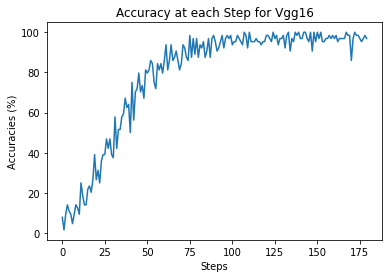

In [ ]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Step for Vgg16")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(accuracy_list)

pyplot.show()

Plotting training loss graph

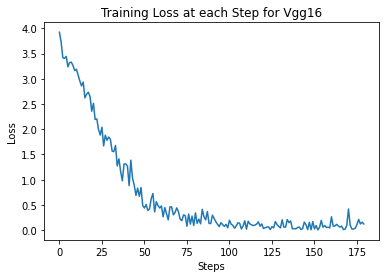

In [ ]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Training Loss at each Step for Vgg16")
pyplot.xlabel("Steps")
pyplot.ylabel("Loss")
pyplot.plot(train_loss)

pyplot.show()

In [ ]:
from torch.autograd import Variable
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
import torch.nn.functional as F

pred_y = []
lable_given_img = []

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)

        for i in pred :
          pred_y.append(i.abs().tolist())
        for i in target :
          lable_given_img.append(i.abs().tolist())

        correct += (pred == target).sum()
        
    loss /= len(data_loader.dataset)
    test_loss.append(loss)    
    test_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

Testing accuracy corresponding to test_dataLoader

In [ ]:
for epoch in range(num_epochs):
  evaluate(test_dataLoader)

<ipython-input-9-33b125f0acf2>:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Validation loss: 0.24324	Accuracy: 92.82511901855469 %

Average Validation loss: 0.27407	Accuracy: 92.60089874267578 %

Average Validation loss: 0.26792	Accuracy: 92.4327392578125 %

Average Validation loss: 0.24215	Accuracy: 92.7130126953125 %

Average Validation loss: 0.25496	Accuracy: 92.4887924194336 %

Average Validation loss: 0.24988	Accuracy: 92.7690658569336 %

Average Validation loss: 0.23775	Accuracy: 92.7130126953125 %

Average Validation loss: 0.26039	Accuracy: 92.4327392578125 %

Average Validation loss: 0.26089	Accuracy: 92.32063293457031 %

Average Validation loss: 0.24790	Accuracy: 93.21749114990234 %

Average Validation loss: 0.27253	Accuracy: 92.7130126953125 %

Average Validation loss: 0.26306	Accuracy: 92.82511901855469 %

Average Validation loss: 0.25831	Accuracy: 92.4887924194336 %

Average Validation loss: 0.26163	Accuracy: 92.7690658569336 %

Average Validation loss: 0.27867	Accuracy: 92.60089874267578 %

Average Validation loss: 0.24960	Accuracy: 93.44

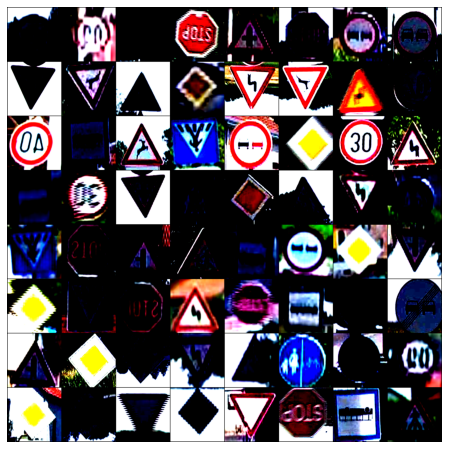

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in test_dataLoader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

Saving Model

In [ ]:
PATH = '/content/Vgg_rmastif.pt'
torch.save({
            'loss': train_loss,
            'accuracy': accuracy_list,
            'test_loss': test_loss,
            'test_accuracy':test_accuracy
            }, PATH)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Printing Confusion Matrix

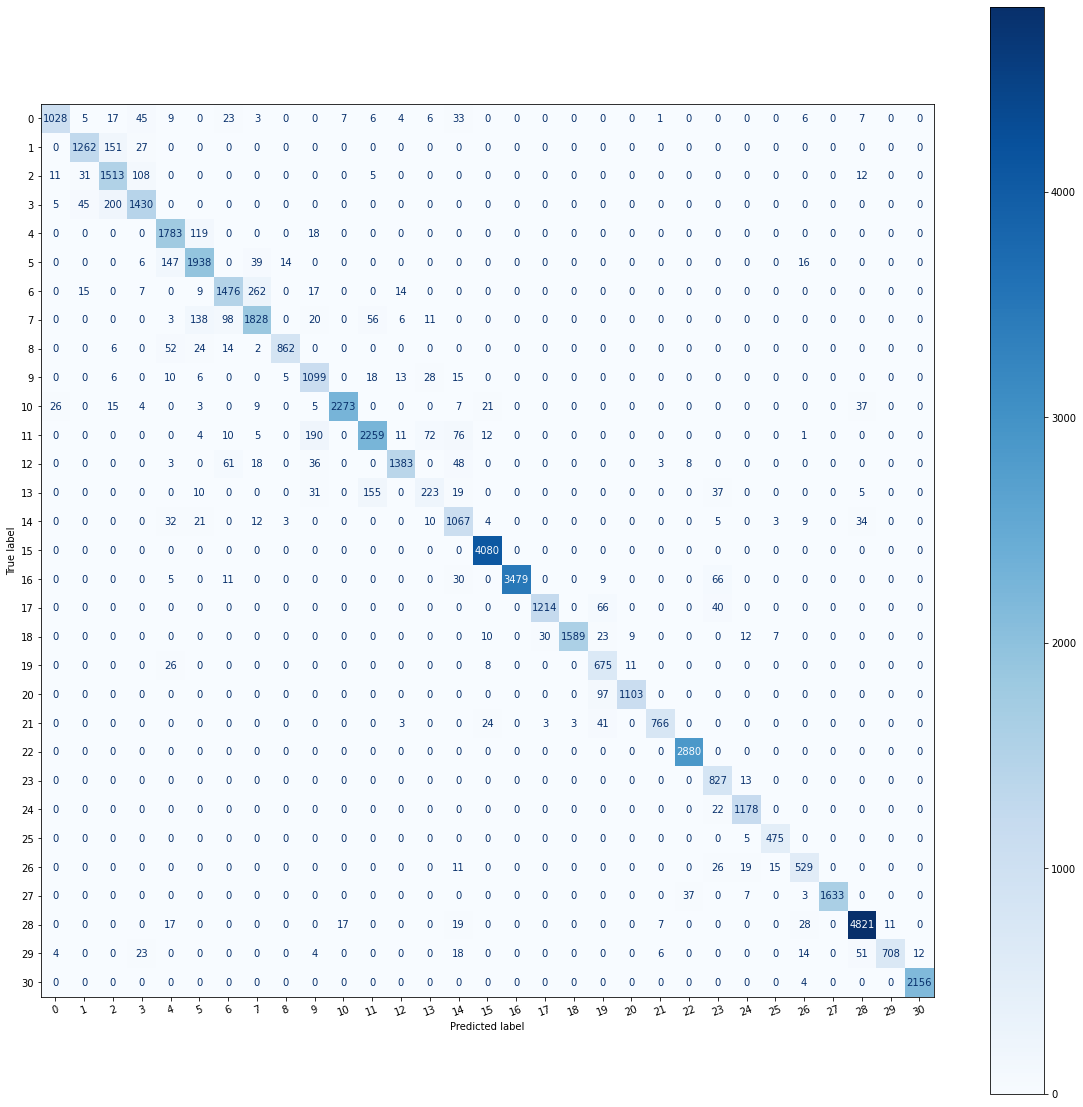

In [ ]:
import matplotlib.pyplot as pyplot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

numClasses = 31
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, numClasses)
plot_confusion_matrix(lable_given_img, pred_y, labels_arr)

Prinitng Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(lable_given_img, pred_y))

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      1200
           1       0.93      0.88      0.90      1440
           2       0.79      0.90      0.84      1680
           3       0.87      0.85      0.86      1680
           4       0.85      0.93      0.89      1920
           5       0.85      0.90      0.87      2160
           6       0.87      0.82      0.85      1800
           7       0.84      0.85      0.84      2160
           8       0.98      0.90      0.93       960
           9       0.77      0.92      0.84      1200
          10       0.99      0.95      0.97      2400
          11       0.90      0.86      0.88      2640
          12       0.96      0.89      0.92      1560
          13       0.64      0.46      0.54       480
          14       0.79      0.89      0.84      1200
          15       0.98      1.00      0.99      4080
          16       1.00      0.97      0.98      3600
          17       0.97    